In [1]:
!pip install tsmoothie 
# a python library for time-series smoothing and outlier detection in a vectorized way

In [2]:
import pandas as pd #for managing the dataframe

import tsmoothie #for the Kalman filter, it is an efficient recursive filter that evaluates the state of a dynamic system starting from a series of measurements subject to noise.
from sklearn.preprocessing import RobustScaler #for preprocessing, it scales features using statistics that are robust to outliers.
import numpy as np #for the e_logarithmic filter (and also some other mathematical operations)

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout #the two main technlogies of the model layers
from tensorflow.keras import optimizers #for the training of the model
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import mean_squared_error, r2_score #for evaluating model performances
from sklearn.model_selection import train_test_split

from google.colab import drive #to import data from Google Drive

import matplotlib.pyplot as plt #to plot losses of models

from sklearn.linear_model import LinearRegression #for the slope and the value of Y at X=0 of the linear trend line


random_state = 2021

#https://towardsdatascience.com/stop-using-numpy-random-seed-581a9972805f


In [3]:
'''Function for making sequences (blocks) of test and train data'''
def building_data_sequences(data, timesteps=10): #timesteps means how many days we consider for each block

    X=[]              
    y_MPN10P = [] 
    y_HPN10P = []
    y_LPN10P = []
    y_HPN1P = []
    y_LPN1P = []

    for i in range(len(data)-timesteps+1):  #how it works: every timesteps (e.g. 10 days) a block is constituted and for each block data and labels are saved


        X.append(data[i:(i+timesteps),:5])
        y_MPN10P.append(data[i+timesteps-1,5])
        y_HPN10P.append(data[i+timesteps-1,6])
        y_LPN10P.append(data[i+timesteps-1,7])
        y_HPN1P.append(data[i+timesteps-1,8])
        y_LPN1P.append(data[i+timesteps-1,9])
    
    return np.array(X), [np.array(y_MPN10P), np.array(y_HPN10P), np.array(y_LPN10P), np.array(y_HPN1P), np.array(y_LPN1P)]

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#change of course the path if you're using this code as base for something else
dataset_path = "/content/drive/MyDrive/iLab Unit /Ago/proceedit 20220217 iLab - dySPP- S&P500 Knowledge base - OHLCV_MPN10P_data.csv"
ohlcv_mpn10p_data=pd.read_csv(dataset_path)
ohlcv_mpn10p_data.head() #let's have a look to the dataset

,id,uuid,DCP_date_current_period,OPCP_open_price_current_period,HPCP_high_price_current_period,LPCP_low_price_current_period,CPCP_close_price_current_period,ACPCP_adjusted_close_price_current_period,VTCP_volume_of_transactions_current_period,MPN10P_median_price_next_10_periods,HPN10P_highest_price_next_10_periods,LPN10P_lowest_price_next_10_periods,HPN1P_high_price_next_1_period,LPN1P_low_price_next_1_period
0,1,NaN,03-01-2000,"1,469.25","1,478.00","1,438.36","1,455.22","1,455.22","93,18,00,000","1,441.47","1,473.00","1,377.68","1,455.22","1,397.43"
1,2,NaN,04-01-2000,"1,455.22","1,455.22","1,397.43","1,399.42","1,399","1,00,90,00,000","1,441.78","1,473.00","1,377.68","1,413.27","1,377.68"
2,3,NaN,05-01-2000,"1,399.42","1,413.27","1,377.68","1,402.11","1,402","1,08,55,00,000","1,448.00","1,473.00","1,392.10","1,411.90","1,392.10"
3,4,NaN,06-01-2000,"1,402.11","1,411.90","1,392.10","1,403.45","1,403","1,09,23,00,000","1,449.18","1,473.00","1,400.73","1,441.47","1,400.73"
4,5,NaN,07-01-2000,"1,403.45","1,441.47","1,400.73","1,441.47","1,441","1,22,52,00,000","1,449.68","1,473.00","1,395.42","1,464.36","1,441.47"


In [6]:
ohlcv_mpn10p_data = ohlcv_mpn10p_data.replace(',','', regex=True) #remove the ',' otherwise it's impossible to deal with numbers in the dataset
ohlcv_mpn10p_data.tail() #ohoh there's a problem with the last row

,id,uuid,DCP_date_current_period,OPCP_open_price_current_period,HPCP_high_price_current_period,LPCP_low_price_current_period,CPCP_close_price_current_period,ACPCP_adjusted_close_price_current_period,VTCP_volume_of_transactions_current_period,MPN10P_median_price_next_10_periods,HPN10P_highest_price_next_10_periods,LPN10P_lowest_price_next_10_periods,HPN1P_high_price_next_1_period,LPN1P_low_price_next_1_period
5562,5563,NaN,11-02-2022,4506.27,4526.33,4401.41,4418.64,4419,4164960000,4429.48,4489.55,4364.84,4426.22,4364.84
5563,5564,NaN,14-02-2022,4412.61,4426.22,4364.84,4401.67,4402,3466170000,4455.75,4489.55,4373.81,4472.77,4429.28
5564,5565,NaN,15-02-2022,4429.28,4472.77,4429.28,4471.07,4471,3363200000,4455.91,4489.55,4373.81,4489.55,4429.68
5565,5566,NaN,16-02-2022,4455.75,4489.55,4429.68,4475.01,4475,3478750000,4416.55,4456.06,4373.81,4456.06,4373.81
5566,5567,NaN,17-02-2022,4456.06,4456.06,4373.81,4380.26,4380,3596510000,#NUM!,#NUM!,#NUM!,NaN,NaN


In [7]:
ohlcv_mpn10p_data = ohlcv_mpn10p_data[:-1] #simply remove the last row

In [8]:
ohlcv_mpn10p_data.tail() #now it's perfect!

,id,uuid,DCP_date_current_period,OPCP_open_price_current_period,HPCP_high_price_current_period,LPCP_low_price_current_period,CPCP_close_price_current_period,ACPCP_adjusted_close_price_current_period,VTCP_volume_of_transactions_current_period,MPN10P_median_price_next_10_periods,HPN10P_highest_price_next_10_periods,LPN10P_lowest_price_next_10_periods,HPN1P_high_price_next_1_period,LPN1P_low_price_next_1_period
5561,5562,NaN,10-02-2022,4553.24,4588.92,4484.31,4504.08,4504,4490500000,4429.68,4526.33,4364.84,4526.33,4401.41
5562,5563,NaN,11-02-2022,4506.27,4526.33,4401.41,4418.64,4419,4164960000,4429.48,4489.55,4364.84,4426.22,4364.84
5563,5564,NaN,14-02-2022,4412.61,4426.22,4364.84,4401.67,4402,3466170000,4455.75,4489.55,4373.81,4472.77,4429.28
5564,5565,NaN,15-02-2022,4429.28,4472.77,4429.28,4471.07,4471,3363200000,4455.91,4489.55,4373.81,4489.55,4429.68
5565,5566,NaN,16-02-2022,4455.75,4489.55,4429.68,4475.01,4475,3478750000,4416.55,4456.06,4373.81,4456.06,4373.81


In [9]:
#building the dataframe with just the necessary columns (removing 'id', 'uuid' and 'ACPCP_adjusted_close_price_current_period' column) 
df = ohlcv_mpn10p_data[['OPCP_open_price_current_period','HPCP_high_price_current_period','LPCP_low_price_current_period',
                        'CPCP_close_price_current_period','VTCP_volume_of_transactions_current_period','MPN10P_median_price_next_10_periods',
                        'HPN10P_highest_price_next_10_periods', 'LPN10P_lowest_price_next_10_periods', 'HPN1P_high_price_next_1_period', 
                        'LPN1P_low_price_next_1_period' ]]

#renaming columns to have a more compact and a better reading of the df
df = df.rename(columns={"OPCP_open_price_current_period":"OPCP", "HPCP_high_price_current_period":"HPCP", 
                        "LPCP_low_price_current_period":"LPCP", "CPCP_close_price_current_period":"CPCP", 
                        "VTCP_volume_of_transactions_current_period":"VTCP", "MPN10P_median_price_next_10_periods":"MPN10P",
                        "HPN10P_highest_price_next_10_periods":"HPN10P", 'LPN10P_lowest_price_next_10_periods':'LPN10P',
                        'HPN1P_high_price_next_1_period':'HPN1P','LPN1P_low_price_next_1_period':'LPN1P'
                      })

df.head()

,OPCP,HPCP,LPCP,CPCP,VTCP,MPN10P,HPN10P,LPN10P,HPN1P,LPN1P
0,1469.25,1478.00,1438.36,1455.22,931800000,1441.47,1473.00,1377.68,1455.22,1397.43
1,1455.22,1455.22,1397.43,1399.42,1009000000,1441.78,1473.00,1377.68,1413.27,1377.68
2,1399.42,1413.27,1377.68,1402.11,1085500000,1448.00,1473.00,1392.10,1411.90,1392.10
3,1402.11,1411.90,1392.10,1403.45,1092300000,1449.18,1473.00,1400.73,1441.47,1400.73
4,1403.45,1441.47,1400.73,1441.47,1225200000,1449.68,1473.00,1395.42,1464.36,1441.47


In [10]:
print("Number of NaN values:")
print(df.isna().sum()) #let's check also whether there are missing values or not

Number of NaN values:
OPCP      0
HPCP      0
LPCP      0
CPCP      0
VTCP      0
MPN10P    0
HPN10P    0
LPN10P    0
HPN1P     0
LPN1P     0
dtype: int64


In [11]:
df_array=np.zeros((df.shape), dtype=np.float64) #necessary to deal with filter results
print(df_array)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [12]:
'''Kalman filter (rounding data)'''
kalman_smoother=tsmoothie.KalmanSmoother(component='level_trend',  component_noise={'level':0.1, 'trend':0.1}) #values for Kalman filters parameters 
                                                                                                                #are taken from an example in the original code 
                                                                                                                #of the library

for i in range(len(df.columns)): #this is the more convenient way I've found to apply the filter
  kalman_smoother.smooth(df[df.columns[i]].astype(float))
  df_array[:,i] = kalman_smoother.smooth_data

In [13]:
print(pd.DataFrame(df_array)) #I use pd.DataFrame(array) to print because in this way it's neater

                0            1            2            3             4  \
0     1419.971823  1426.152384  1381.031819  1394.341183  9.563459e+08   
1     1420.629306  1429.384782  1387.003267  1401.473595  1.007628e+09   
2     1417.075273  1429.524661  1392.165453  1409.352456  1.052672e+09   
3     1417.241319  1432.844682  1400.260959  1418.801808  1.082191e+09   
4     1421.816521  1440.252055  1410.460156  1430.213500  1.095597e+09   
...           ...          ...          ...          ...           ...   
5561  4509.336373  4541.536570  4462.287794  4491.557234  3.874515e+09   
5562  4489.976141  4519.474691  4438.901561  4468.723548  3.834804e+09   
5563  4465.732400  4494.689452  4421.977054  4455.576360  3.700815e+09   
5564  4448.824460  4480.205070  4415.939073  4453.962061  3.572054e+09   
5565  4435.859969  4468.562904  4410.486363  4452.852699  3.465504e+09   

                5            6            7            8            9  
0     1410.843023  1439.884584  1350.53

In [14]:
'''E_logarithmic filter (detrending)'''
df_array=np.log(df_array)

In [15]:
print(pd.DataFrame(df_array))

             0         1         2         3          4         5         6  \
0     7.258392  7.262735  7.230586  7.240177  20.678630  7.251943  7.272318   
1     7.258855  7.264999  7.234901  7.245280  20.730865  7.262939  7.282192   
2     7.256350  7.265097  7.238616  7.250886  20.774598  7.270995  7.289047   
3     7.256468  7.267417  7.244414  7.257568  20.802254  7.275824  7.293242   
4     7.259691  7.272573  7.251671  7.265579  20.814565  7.277839  7.295443   
...        ...       ...       ...       ...        ...       ...       ...   
5561  8.413905  8.421021  8.403417  8.409955  22.077686  8.399637  8.420195   
5562  8.409603  8.416151  8.398162  8.404858  22.067384  8.398858  8.415132   
5563  8.404189  8.410652  8.394342  8.401912  22.031819  8.398597  8.410852   
5564  8.400395  8.407424  8.392976  8.401549  21.996407  8.397794  8.406854   
5565  8.397477  8.404822  8.391740  8.401300  21.966124  8.396256  8.402523   

             7         8         9  
0     7.208256

In [16]:
'''Robust scaler (scaling)'''
robust_scaler = RobustScaler()

for i in range(len(df.columns)): #in such a way I can have only a RS for each column
  col_scaled = robust_scaler.fit_transform(df_array[:,i].reshape(-1,1)) 
  df_array[:,i] = col_scaled[:, 0]

In [17]:
'''splitting training and testing data'''
train_data, test_data = train_test_split(df_array, train_size=0.9, shuffle = False,random_state=2021) #with shuffle=False, data is acquired in sequence

In [18]:
print(train_data.shape[0],"days for training.")
print(test_data.shape[0],"days for testing.")

5009 days for training.
557 days for testing.


In [19]:
X_train, y_train = building_data_sequences(train_data) #see Functions section above
X_test, y_test = building_data_sequences(test_data) 

##Model

In [20]:
input_shape=((X_train).shape[1],(X_train).shape[2])
print("Input shape obtained is:",input_shape)

Input shape obtained is: (10, 5)


In [21]:
'''Model parameters: in order to understand, consult the original documentation (case_version_cat Tab) '''
n_epochs = 100
batch_size = 32
# twoexp_nodes_number_layer_1 = 7
# twoexp_nodes_number_layer_2 = 10
# twoexp_nodes_number_layer_3 = 7
# twoexp_nodes_number_layer_4 = 6
# twoexp_nodes_number_layer_5 = 0
lr=1e-5 #a couple of test with lower values

In [22]:
targets = ['MPN10P']
models = {} #to store everything regarding models: name, model itself, lossess, train and test predictions, evaluations and so on

histories = {}

train_mse, test_mse = [], []

analytical_parameters = {
    'slope_ratio':[],
    'intercept_ratio':[],
    'rsqr_ratio':[],
    'mad_ratio':[],
    'slope_predact':[],
    'intercept_predact':[],
    'rsqr_predact':[],
    'mad_predact':[]
    }
actual = ohlcv_mpn10p_data.iloc[9:,:].reset_index().drop(['index'], axis=1)
actual_mpn10p = np.array(actual.iloc[:,9].astype(float))
slp_first, slp_second = [], []
interc_first, interc_second = [], []
rsqr_first, rsqr_second = [], []
n_iterations = 30

In [23]:
from tensorflow import keras
from matplotlib import pyplot
from keras import regularizers

for i in range(len(targets)):

  print("Training model for ", targets[i])
  model = tf.keras.Sequential()

  '''These are the 5 layers that characterize each model (see case_version_cat Tab)'''

  model.add(LSTM(128,input_shape=input_shape,return_sequences=True,activation='relu',activity_regularizer=regularizers.l2(lr)))
  model.add(Dropout(0.2))
  model.add(LSTM(1024, return_sequences=True))
  model.add(LSTM(128))
  model.add(Dense(64))
  model.add(Dense(1))

  #compiling model
  model.compile(optimizer = 'SGD', loss = 'mean_squared_error')

Training model for  MPN10P


In [24]:
  early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
  #patience -  the number of epochs to wait before early stop if no progress on the validation set. The patience is often set somewhere between 10 and 100 (10 or 20 is more common), but it really depends on your dataset and network.

  #fitting model
  hist = model.fit(X_train, y_train[i], batch_size=batch_size, epochs=n_epochs,validation_split = 0.2,shuffle = False)
  #Shuffle - whether to shuffle the training data before each epoch
  #we can acheive the reproducible results with the help of random_state =2021


  #enriching models vocabulary 
  models[targets[i]] = {'model': model, 'train':{'val_loss': hist.history['val_loss']}, 'test':{}} 
  # plot training history

  print(models[targets[i]])

Epoch 1/100
125/125 [==============================] - 69s 525ms/step - loss: 0.0351 - val_loss: 0.1678
Epoch 2/100
125/125 [==============================] - 65s 522ms/step - loss: 0.0350 - val_loss: 0.1544
Epoch 3/100
125/125 [==============================] - 65s 524ms/step - loss: 0.0226 - val_loss: 0.1353
Epoch 4/100
125/125 [==============================] - 66s 529ms/step - loss: 0.0132 - val_loss: 0.1168
Epoch 5/100
125/125 [==============================] - 65s 519ms/step - loss: 0.0082 - val_loss: 0.0983
Epoch 6/100
125/125 [==============================] - 64s 509ms/step - loss: 0.0065 - val_loss: 0.0821
Epoch 7/100
125/125 [==============================] - 63s 506ms/step - loss: 0.0059 - val_loss: 0.0690
Epoch 8/100
125/125 [==============================] - 64s 515ms/step - loss: 0.0057 - val_loss: 0.0577
Epoch 9/100
125/125 [==============================] - 65s 518ms/step - loss: 0.0054 - val_loss: 0.0484
Epoch 10/100
125/125 [==============================] - 64s 510m

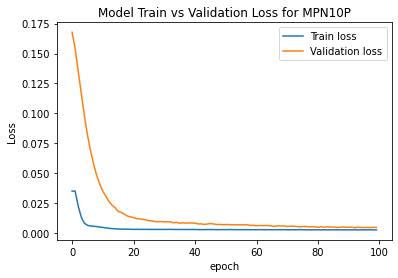

In [35]:
  pyplot.plot(hist.history['loss'], label='train_loss')
  pyplot.plot(hist.history['val_loss'], label='val_loss')
  plt.title('Model Train vs Validation Loss for ' + targets[0])
  plt.ylabel('Loss')
  plt.xlabel('epoch')
  pyplot.legend(['Train loss', 'Validation loss'], loc='upper right')
  pyplot.show() 
  print()

In [36]:
'''Enriching the models vocabulary with predictions about training set'''
for key in models:

  idx = list(models.keys()).index(key)
  train_predictions = models[key]['model'].predict(X_train) #predict predictions
  train_predictions = np.exp(robust_scaler.inverse_transform(train_predictions)) #convert prediction
  models[key]['train']['predictions'] = train_predictions #attach prediction
  y_transformed = np.exp(robust_scaler.inverse_transform(y_train[idx].reshape(-1,1))) #the same here for the labels (in order to compare them with the predictions)
  mse = mean_squared_error(y_transformed, train_predictions) #mse
  r2 = r2_score(y_transformed, train_predictions) #r2 score
  models[key]['train']['evaluation'] = {'mse': mse, 'r2' : r2 } #save them in the vocabulary

In [37]:
'''Enriching the models vocabulary with predictions about test set'''
for key in models:
 
  idx = list(models.keys()).index(key)
  test_predictions = models[key]['model'].predict(X_test) 
  test_predictions = np.exp(robust_scaler.inverse_transform(test_predictions)) 
  models[key]['test']['predictions'] = test_predictions 
  y_transformed = np.exp(robust_scaler.inverse_transform(y_test[idx].reshape(-1,1))) 
  mse = mean_squared_error(y_transformed, test_predictions) 
  r2 = r2_score(y_transformed, test_predictions) 
  models[key]['test']['evaluation'] = {'mse': mse, 'r2' : r2 } 

In [38]:
'''Notice that, in general, while on the training set the model is good (even if the mse is still high),
on the test set the model is very bad with a terrible mse and a r2 score which is strangely perfect (nonetheless in some cases it oscillates, but still it's good)'''

for key in models: #for each model, simply print the mse and the r2 score for training and testing
  print('MSE and R2_score for Model_'+key)
  print('       Training:', models[key]['train']['evaluation'])
  print('       Testing:',models[key]['test']['evaluation'])
  print()

MSE and R2_score for Model_MPN10P
       Training: {'mse': 3701.29298816881, 'r2': 0.988953397945579}
       Testing: {'mse': 168050.78851355167, 'r2': 0.562528704104508}



In [39]:
'''Creating the df with all the predictions of the models'''

targets_columns = []

for key in models:

  train_array = np.concatenate(models[key]['train']['predictions']).ravel()
  test_array = np.concatenate(models[key]['test']['predictions']).ravel()
  target_col = np.concatenate((train_array, test_array))
  targets_columns.append(target_col)


targets_df = pd.DataFrame(targets_columns).T
targets_df = targets_df.rename(columns={0:'MPN10P_prediction',1:'HPN10P_prediction',2:'LPN10P_prediction',3:'HPN1P_prediction',4:'LPN1P_prediction'})
targets_df

,MPN10P_prediction
0,1386.928101
1,1392.754150
2,1398.053833
3,1402.751709
4,1406.357422
...,...
5543,3965.480469
5544,3973.668945
5545,3977.623291
5546,3977.315918


In [40]:
targets_df

,MPN10P_prediction
0,1386.928101
1,1392.754150
2,1398.053833
3,1402.751709
4,1406.357422
...,...
5543,3965.480469
5544,3973.668945
5545,3977.623291
5546,3977.315918


In [41]:
'''Creating the df on which attach the predicted results'''
output_df = ohlcv_mpn10p_data.iloc[9:,:].reset_index().drop(['index'], axis=1) #take data after timesteps-1 days
output_df

,id,uuid,DCP_date_current_period,OPCP_open_price_current_period,HPCP_high_price_current_period,LPCP_low_price_current_period,CPCP_close_price_current_period,ACPCP_adjusted_close_price_current_period,VTCP_volume_of_transactions_current_period,MPN10P_median_price_next_10_periods,HPN10P_highest_price_next_10_periods,LPN10P_lowest_price_next_10_periods,HPN1P_high_price_next_1_period,LPN1P_low_price_next_1_period
0,10,NaN,14-01-2000,1449.68,1473.00,1449.68,1465.15,1465,1085900000,1413.49,1465.71,1350.14,1465.15,1451.30
1,11,NaN,18-01-2000,1465.15,1465.15,1451.30,1455.14,1455,1056700000,1408.02,1465.71,1350.14,1461.39,1448.68
2,12,NaN,19-01-2000,1455.14,1461.39,1448.68,1455.90,1456,1087800000,1405.42,1465.71,1350.14,1465.71,1438.54
3,13,NaN,20-01-2000,1455.90,1465.71,1438.54,1445.57,1446,1100700000,1404.09,1454.09,1350.14,1453.18,1439.60
4,14,NaN,21-01-2000,1445.57,1453.18,1439.60,1441.36,1441,1209800000,1404.09,1454.09,1350.14,1454.09,1395.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5552,5562,NaN,10-02-2022,4553.24,4588.92,4484.31,4504.08,4504,4490500000,4429.68,4526.33,4364.84,4526.33,4401.41
5553,5563,NaN,11-02-2022,4506.27,4526.33,4401.41,4418.64,4419,4164960000,4429.48,4489.55,4364.84,4426.22,4364.84
5554,5564,NaN,14-02-2022,4412.61,4426.22,4364.84,4401.67,4402,3466170000,4455.75,4489.55,4373.81,4472.77,4429.28
5555,5565,NaN,15-02-2022,4429.28,4472.77,4429.28,4471.07,4471,3363200000,4455.91,4489.55,4373.81,4489.55,4429.68


In [42]:
output_df=pd.concat([output_df,targets_df], axis=1)
output_df

,id,uuid,DCP_date_current_period,OPCP_open_price_current_period,HPCP_high_price_current_period,LPCP_low_price_current_period,CPCP_close_price_current_period,ACPCP_adjusted_close_price_current_period,VTCP_volume_of_transactions_current_period,MPN10P_median_price_next_10_periods,HPN10P_highest_price_next_10_periods,LPN10P_lowest_price_next_10_periods,HPN1P_high_price_next_1_period,LPN1P_low_price_next_1_period,MPN10P_prediction
0,10,NaN,14-01-2000,1449.68,1473.00,1449.68,1465.15,1465,1085900000,1413.49,1465.71,1350.14,1465.15,1451.30,1386.928101
1,11,NaN,18-01-2000,1465.15,1465.15,1451.30,1455.14,1455,1056700000,1408.02,1465.71,1350.14,1461.39,1448.68,1392.754150
2,12,NaN,19-01-2000,1455.14,1461.39,1448.68,1455.90,1456,1087800000,1405.42,1465.71,1350.14,1465.71,1438.54,1398.053833
3,13,NaN,20-01-2000,1455.90,1465.71,1438.54,1445.57,1446,1100700000,1404.09,1454.09,1350.14,1453.18,1439.60,1402.751709
4,14,NaN,21-01-2000,1445.57,1453.18,1439.60,1441.36,1441,1209800000,1404.09,1454.09,1350.14,1454.09,1395.42,1406.357422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5552,5562,NaN,10-02-2022,4553.24,4588.92,4484.31,4504.08,4504,4490500000,4429.68,4526.33,4364.84,4526.33,4401.41,NaN
5553,5563,NaN,11-02-2022,4506.27,4526.33,4401.41,4418.64,4419,4164960000,4429.48,4489.55,4364.84,4426.22,4364.84,NaN
5554,5564,NaN,14-02-2022,4412.61,4426.22,4364.84,4401.67,4402,3466170000,4455.75,4489.55,4373.81,4472.77,4429.28,NaN
5555,5565,NaN,15-02-2022,4429.28,4472.77,4429.28,4471.07,4471,3363200000,4455.91,4489.55,4373.81,4489.55,4429.68,NaN


In [43]:
output_df['MPN10P_prediction'].tail(20)

5537    3927.149414
5538    3923.450684
5539    3925.587646
5540    3932.793945
5541    3943.140137
5542    3954.622803
5543    3965.480469
5544    3973.668945
5545    3977.623291
5546    3977.315918
5547    3973.623291
5548            NaN
5549            NaN
5550            NaN
5551            NaN
5552            NaN
5553            NaN
5554            NaN
5555            NaN
5556            NaN
Name: MPN10P_prediction, dtype: float32

In [44]:
'''Save the output file on drive'''
#change of course the path if you're using this code as base for something else
output_path='/content/drive/MyDrive/iLab Unit /Ago/'
output_df.to_csv(output_path+'output_file_sgd.csv')